In [1]:
import re
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

interogative = ["which", "whose", "what", "would", "who", "when", "where", "can", "whom", "how", "why", "whether"]
stop_words = list(ENGLISH_STOP_WORDS)
for inter in interogative:
    stop_words.remove(inter)

def parse_file(f, d, stop_words):
    """
    Parameters
    ----------
    f         :     string, filename to be read
    
    d         :     dictionary where results are to be stored
    
    
    Returns
    -------
    d         :     updated dictionary
    """
    
    with open('./development_set/%s' %f, 'r') as myfile:
        speech = myfile.read().replace('\n', '').strip("'").strip("`").strip("-")
        edit1 = re.sub(r'[^\w]\ ', '', speech)
        edit2 = re.sub(r'mr\w*\ ', '', edit1)
        edit3 = re.sub(r'ms\w*\ ', '', edit2)
        edit4 = re.sub(r'\w\w\d+\ ', '', edit3)
        
        list_of_words = edit4.strip().lower().split(' ')
        
        for word in list_of_words:
            word.replace("`", '')
            if word not in stop_words:
                if word not in d.keys():
                    d[word] = 1
                else:
                    d[word] += 1
    return d
#R/D -> Repbulican/Democrat
#O/M -> Omit/Mention
#Y/N -> Yes/No


#Declare Dictionaries
word_dict_RN = {}
word_dict_RY = {}
word_dict_DN = {}
word_dict_DY = {}

#Initialize Vars
indir = './development_set'

totals = np.zeros(5)
names = ['RN', 'RY', 'DN', 'DY']
#Iterate over all files where each file is a speech
for filename in os.listdir(indir):
    if filename.endswith("RON.txt") or filename.endswith("RMN.txt"):
        word_dict_RN = parse_file(filename, word_dict_RN, stop_words)
        totals[0] += 1
    if filename.endswith("ROY.txt") or filename.endswith("RMY.txt"):
        word_dict_RY = parse_file(filename, word_dict_RY, stop_words)
        totals[1] += 1
    if filename.endswith("DON.txt") or filename.endswith("DMN.txt"):
        word_dict_DN = parse_file(filename, word_dict_DN, stop_words)
        totals[2] += 1
    if filename.endswith("DOY.txt") or filename.endswith("DMY.txt"):
        word_dict_DY = parse_file(filename, word_dict_DY, stop_words)
        totals[3] += 1

totals[4] = 1.0
print totals

[  11.  356.  291.   44.    1.]


In [2]:
#import nltk, sentisynset, word_tokenize, pos_tag

dictionaries = [word_dict_RN, word_dict_RY, word_dict_DN, word_dict_DY]
status = ['RN', 'RY', 'DN', 'DY', 'total']

total = {}

for i,dictionary in enumerate(dictionaries):
    for key in dictionary.keys():
        if key[0] == '`':
            dictionary.pop(key, None)
            continue
        if key not in total.keys():
            total[key] = dictionary[key]
        else:
            total[key] += dictionary[key]

key_list = []
for d in dictionaries:
    for key in d.keys():
        if key not in key_list:
            if total[key] > 1:
                key_list.append(key)

table = pd.DataFrame(index = key_list)
for s in status:
    table[s] = np.zeros(len(key_list))

dictionaries.append(total)
for i, d in enumerate(dictionaries):
    for j, word in enumerate(key_list):
        if word not in d.keys():
            continue
        table[status[i]][j] = d[word]

for i in range(4):
    table[status[i]] = table[status[i]] * 1.0 / totals[i]

table.to_csv("edav_table.csv")

In [3]:
def parse_file_forlr(f):
    """
    Parameters
    ----------
    f         :     string, filename to be read
    
    
    Returns
    -------
    speeches  :     list of strings, content of each speech
    
    labels    :     list of strings, tags for each speech
    """
    
    with open('./development_set/%s' %f, 'r') as myfile:
        speech = myfile.read().replace('\n', '').strip("'").strip("`").strip("-")
        edit1 = re.sub(r'[^\w]\ ', '', speech)
        edit2 = re.sub(r'mr\w*\ ', '', edit1)
        edit3 = re.sub(r'ms\w*\ ', '', edit2)
        edit4 = re.sub(r'\w\w\d+\ ', '', edit3)
        out = edit4.strip().lower()
      
    if f.endswith("RON.txt") or f.endswith("RMN.txt"):
        label = 'RN'
    if f.endswith("ROY.txt") or f.endswith("RMY.txt"):
        label = 'RY'
    if f.endswith("DON.txt") or f.endswith("DMN.txt"):
        label = 'DN'
    if f.endswith("DOY.txt") or f.endswith("DMY.txt"):
        label = 'DY'

    return out, label

In [4]:
indir = './development_set'

labels = []
speeches = []

#Iterate over all files where each file is a speech
for filename in os.listdir(indir):
    speech, label = parse_file_forlr(filename)
    
    if speech != '' and speech is not None:
        speeches.append(speech)
        labels.append(label)
   
labels_party = []
labels_vote = []

for label in labels:
    if label[0] == 'R':
        labels_party.append(0)
    if label[0] == 'D':
        labels_party.append(1)
    if label[1] == 'N':
        labels_vote.append(0)
    if label[1] == 'Y':
        labels_vote.append(1)

print len(speeches), len(labels_vote), len(labels_party)

702 702 702


In [5]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(CountVectorizer(token_pattern = r"\b\w\w+\b", stop_words='english', ngram_range=(2,2)),
                     LogisticRegression())

param_grid = {'logisticregression__C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid = GridSearchCV(pipe, param_grid = param_grid, cv=5, scoring='f1_macro')
grid.fit(speeches, labels)

print(grid.best_params_)

pipe2 = make_pipeline(CountVectorizer(token_pattern = r"\b\w\w+\b", stop_words='english'),
                     LogisticRegression(C=10))

scores = cross_val_score(pipe2, speeches, labels_party, cv=5, scoring='roc_auc')
print scores, np.mean(scores)

scores = cross_val_score(pipe2, speeches, labels_vote, cv=5, scoring='roc_auc')
print scores, np.mean(scores)

scores = cross_val_score(pipe2, speeches, labels, cv=5, scoring='f1_macro')
print scores, np.mean(scores)

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


{'logisticregression__C': 1000}
[ 0.55909641  0.49415087  0.6112247   0.58311184  0.57708035] 0.564932833058
[ 0.60471311  0.62131148  0.72458333  0.61604167  0.55697917] 0.624725751366
[ 0.25161884  0.48469662  0.29504049  0.2910143   0.31421107] 0.327316262312


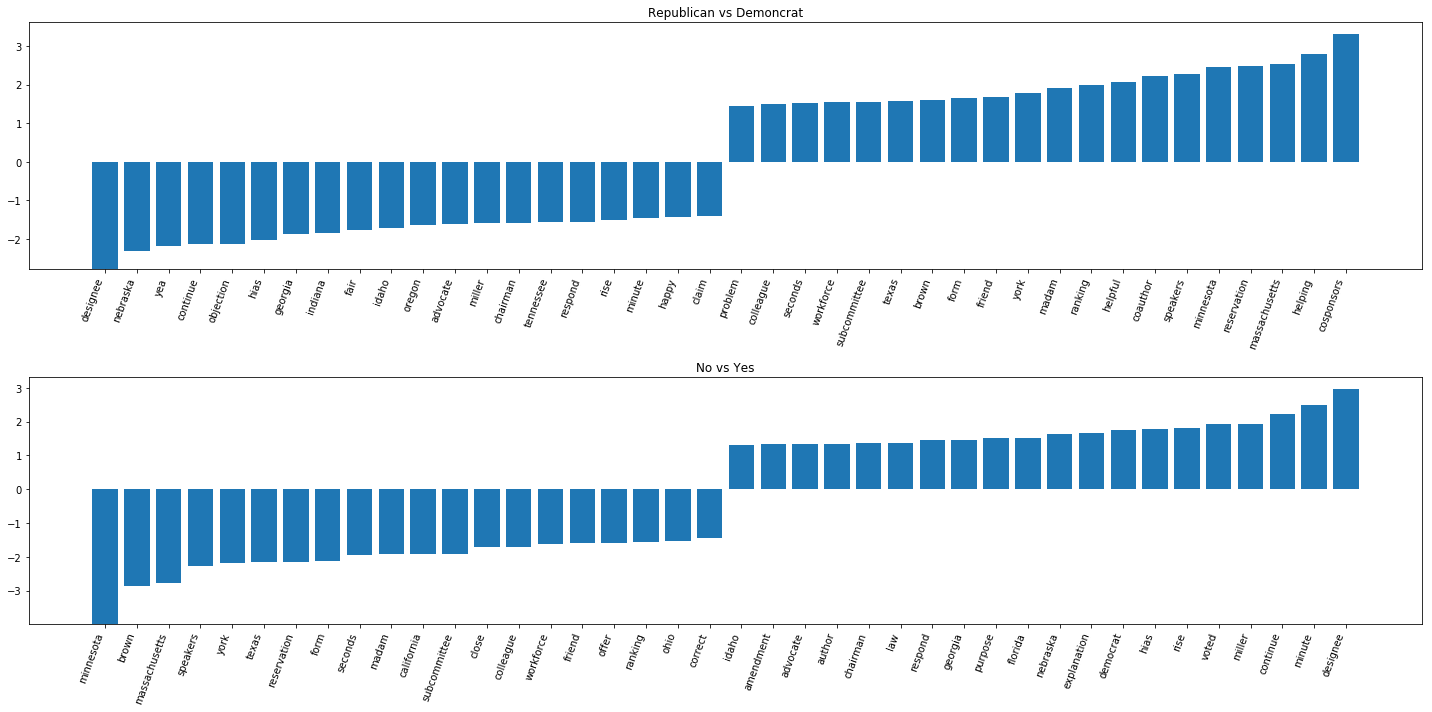

In [6]:
import matplotlib.pyplot as plt

vect = CountVectorizer(token_pattern = r"\b\w\w+\b", stop_words='english')
transformed_speech = vect.fit_transform(speeches)


def plot_other_features(coef, feature_names, top_n=20, ax=None):
    if ax is None:
        ax = plt.gca()

    inds = np.argsort(coef)
    
    low = inds[:top_n]
    high = inds[-top_n:]
    
    important_coef = np.hstack([low, high])
    
    myrange = range(len(important_coef))
    
    ax.bar(myrange, coef[important_coef])
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[important_coef], rotation=70, ha="right")
    
    
def extract_features(coef, feature_names, top_n = 20):
    inds = np.argsort(coef)
    
    low = inds[:top_n]
    high = inds[-top_n:]
    
    return coef[low], feature_names[low], coef[high], feature_names[high]

#Extract coefs and feature names
lr_model_party = LogisticRegression(C=10).fit(transformed_speech, labels_party)
coef_party = lr_model_party.coef_.T

lr_model_vote = LogisticRegression(C=10).fit(transformed_speech, labels_vote)
coef_vote = lr_model_vote.coef_.T

feature_names = np.array(vect.get_feature_names())


#Plots
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

axes[0].set_title("Republican vs Demoncrat")
axes[1].set_title("No vs Yes")
plot_other_features(coef_party[:,0], feature_names, top_n = 20, ax=axes[0])
plot_other_features(coef_vote[:,0], feature_names, top_n = 20, ax=axes[1])
plt.tight_layout()  
plt.show()

In [7]:
#Extract names and coefs to table
lc, fn_lc, hc, fn_hc = extract_features(coef_party[:,0], feature_names)

r_v_d_uni = pd.DataFrame.from_dict({
    "Republican Coef" : np.abs(lc),
    "Republican Features" : fn_lc,
    "Democratic Coef" : hc,
    "Democratic Features" : fn_hc    
})

lc, fn_lc, hc, fn_hc = extract_features(coef_vote[:,0], feature_names)

n_v_y_uni = pd.DataFrame({
    "No Coef" : np.abs(lc),
    "No Features" : fn_lc,
    "Yes Coef" : hc,
    "Yes Features" : fn_hc
})


In [8]:
pipe = make_pipeline(CountVectorizer(token_pattern = r"\b\w\w+\b", stop_words='english', ngram_range=(2,2)),
                     LogisticRegression())

param_grid = {'logisticregression__C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid = GridSearchCV(pipe, param_grid = param_grid, cv=5, scoring='f1_macro')
grid.fit(speeches, labels)

print(grid.best_params_)

pipe2 = make_pipeline(CountVectorizer(token_pattern = r"\b\w\w+\b", stop_words='english', ngram_range=(2,2)),
                     LogisticRegression(C=1000))



scores = cross_val_score(pipe2, speeches, labels_party, cv=5, scoring='roc_auc')
print scores, np.mean(scores)

scores = cross_val_score(pipe2, speeches, labels_vote, cv=5, scoring='roc_auc')
print scores, np.mean(scores)

scores = cross_val_score(pipe2, speeches, labels, cv=5, scoring='f1_macro')
print scores, np.mean(scores)

{'logisticregression__C': 1000}
[ 0.56908027  0.61254538  0.71161317  0.56900429  0.510734  ] 0.594595423475
[ 0.52192623  0.67766393  0.75479167  0.571875    0.50854167] 0.606959699454
[ 0.25362677  0.32614465  0.39503222  0.29645191  0.23743083] 0.301737275446


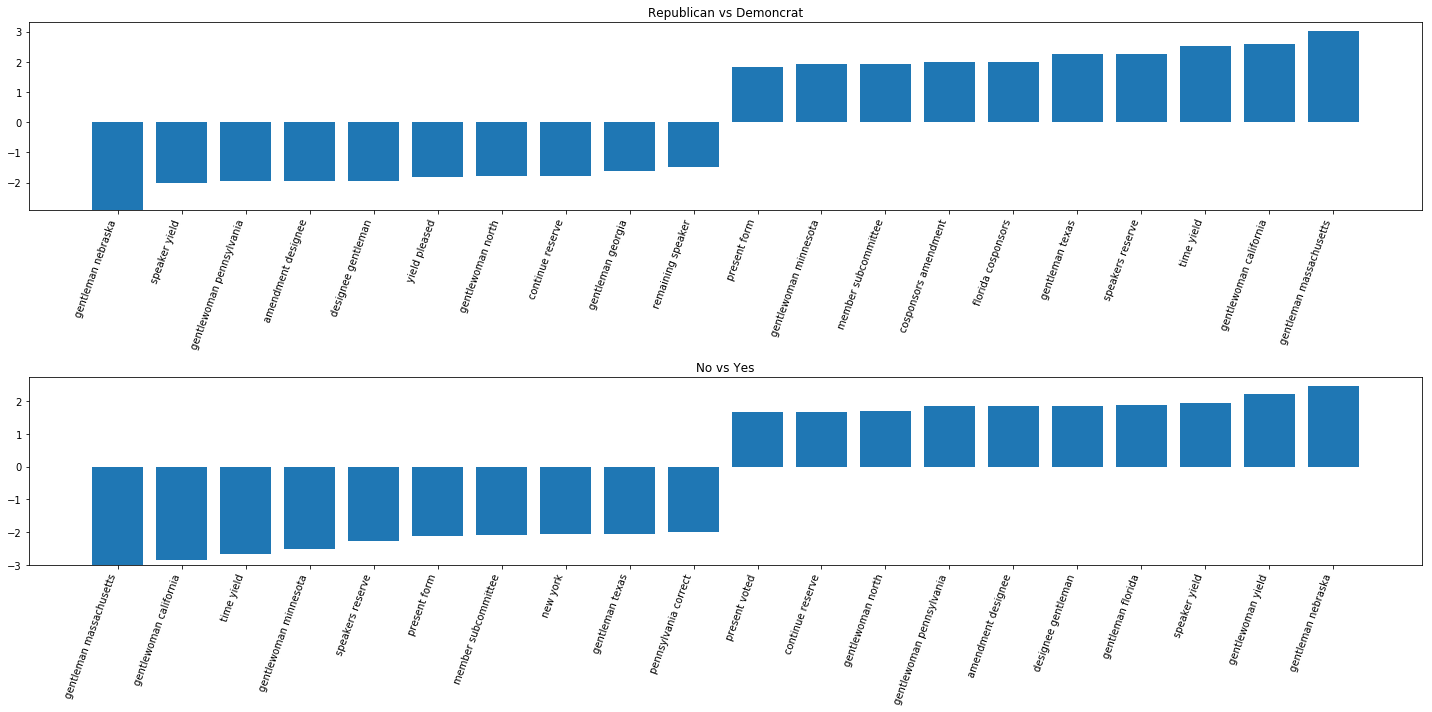

In [9]:
vect = CountVectorizer(token_pattern = r"\b\w\w+\b", stop_words='english', ngram_range=(2,2))
transformed_speech = vect.fit_transform(speeches)

lr_model_party = LogisticRegression(C=10).fit(transformed_speech, labels_party)
coef_party = lr_model_party.coef_.T

lr_model_vote = LogisticRegression(C=10).fit(transformed_speech, labels_vote)
coef_vote = lr_model_vote.coef_.T


feature_names = np.array(vect.get_feature_names())

fig, axes = plt.subplots(2, 1, figsize=(20, 10))

axes[0].set_title("Republican vs Demoncrat")
axes[1].set_title("No vs Yes")
plot_other_features(coef_party[:,0], feature_names, top_n = 10, ax=axes[0])
plot_other_features(coef_vote[:,0], feature_names, top_n = 10, ax=axes[1])
plt.tight_layout()  
plt.show()

In [12]:
lc, fn_lc, hc, fn_hc = extract_features(coef_party[:,0], feature_names)

r_v_d_bi = pd.DataFrame({
    "Republican Coef" : np.abs(lc),
    "Republican Features" : fn_lc,
    "Democratic Coef" : hc,
    "Democratic Features" : fn_hc    
})

lc, fn_lc, hc, fn_hc = extract_features(coef_vote[:,0], feature_names)

n_v_y_bi = pd.DataFrame({
    "No Coef" : np.abs(lc),
    "No Features" : fn_lc,
    "Yes Coef" : hc,
    "Yes Features" : fn_hc
})

print n_v_y_bi

     No Coef              No Features  Yes Coef              Yes Features
0   3.005533  gentleman massachusetts  1.259881          gentleman oregon
1   2.843354   gentlewoman california  1.260211       objection amendment
2   2.670912               time yield  1.273673         unanimous consent
3   2.521707    gentlewoman minnesota  1.280535          jersey cosponsor
4   2.275241         speakers reserve  1.369918             yield pleased
5   2.117843             present form  1.444069             ask unanimous
6   2.082534      member subcommittee  1.486270         remaining speaker
7   2.069444                 new york  1.493849         gentleman georgia
8   2.059448          gentleman texas  1.510997            time gentleman
9   2.006256     pennsylvania correct  1.612753              yield minute
10  1.807316               know names  1.665321             present voted
11  1.728133            gentleman new  1.679839          continue reserve
12  1.670018           ranking member 

In [11]:
r_v_d_uni.to_csv('r_v_d_uni.csv')
r_v_d_bi.to_csv('r_v_d_bi.csv')
n_v_y_uni.to_csv('n_v_y_uni.csv')
n_v_y_bi.to_csv('n_v_y_bi.csv')